Лабораторная работа 2: «Разработка сверточной нейронной сети с использованием PyTorch»

Загрузка и проверка данных Cifar-10

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
batch_size = 128

transform = transforms.Compose([transforms.ToTensor()])

train_data = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform)

print(f"Размер тренировочной выборки: {train_data.data.shape}")
print(f"Размер тестовой выборки: {test_data.data.shape}")

Files already downloaded and verified
Files already downloaded and verified
Размер тренировочной выборки: (50000, 32, 32, 3)
Размер тестовой выборки: (10000, 32, 32, 3)


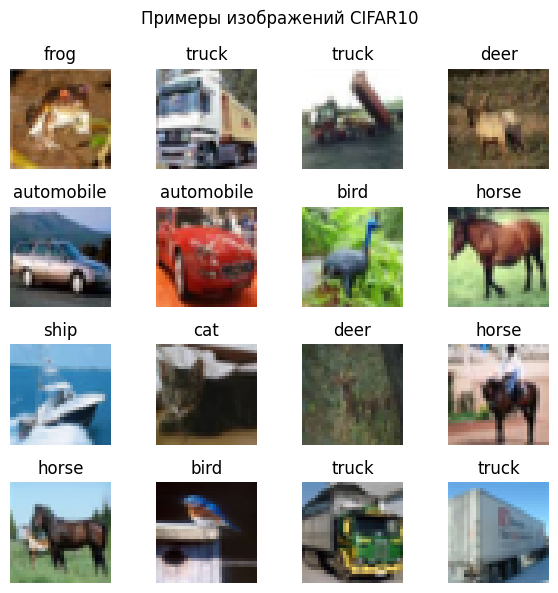

In [3]:
dataset = train_data
size = 4
fig, axs = plt.subplots(size, size, figsize=(6,6))
fig.suptitle("Примеры изображений CIFAR10")

for i in range(size):
    for j in range(size):
        idx = i * size + j
        axs[i, j].imshow(dataset.data[idx], cmap=plt.cm.binary)
        axs[i, j].axis('off')
        axs[i, j].set_title(dataset.classes[dataset.targets[idx]])
plt.tight_layout()
plt.show()

ResNet18

In [4]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True, num_workers=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, pin_memory=True, num_workers=4, shuffle=False)

In [5]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.act = nn.ReLU()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, input):
        res = self.act(self.bn1(self.conv1(input)))
        res = self.bn2(self.conv2(res))
        res += self.shortcut(input)
        res = self.act(res)
        return res

class ResNet(nn.Module):
    def __init__(self, block, num_blocks = [2,2,2,2]):
        num_classes=10
        super(ResNet, self).__init__()
        self.act = nn.ReLU()

        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer64 = self.layer(block, 64, num_blocks[0], stride=1)
        self.layer128 = self.layer(block, 128, num_blocks[1], stride=2)
        self.layer256 = self.layer(block, 256, num_blocks[2], stride=2)
        self.layer512 = self.layer(block, 512, num_blocks[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flat = nn.Flatten(start_dim=1)
        self.linear = nn.Linear(512, num_classes)

    def layer(self, block, planes, num_blocks, stride):
        layers = []
        strides = [stride] + (num_blocks-1)*[1]
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, input):
        res = self.act(self.bn1(self.conv1(input)))

        res = self.layer64(res)
        res = self.layer128(res)
        res = self.layer256(res)
        res = self.layer512(res)

        res = self.avg_pool(res)
        res = self.flat(res)
        res = self.linear(res)

        return res

def ResNet18():
    return ResNet(BasicBlock, num_blocks=[2, 2, 2, 2])

In [6]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

model = ResNet18().to(device)

learning_rate = 3e-4
epochs = 25

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_for_graph, acc_for_graph = [], []

for e in range(epochs):
    loss_arr, acc_arr = [], []

    start = time.time()
    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()

        model.train()
        res = model(X_batch)
        loss = loss_func(res, Y_batch)
        loss.backward()
        optimizer.step()

        acc_arr.append(torch.mean(torch.argmax(res, dim = 1) == Y_batch, dtype=torch.float32))
        loss_arr.append(loss)

    dur = time.time() - start
    print(f"Epoch {e + 1}/{epochs}, Time: {dur:3f}, Accuracy: {torch.stack(acc_arr).mean():5f}, Loss: {loss.item():5f}")

    loss_for_graph.append(torch.stack(loss_arr).mean().cpu().detach().numpy())
    acc_for_graph.append(torch.stack(acc_arr).mean().cpu().detach().numpy())

Epoch 1/25, Time: 9.482634, Accuracy: 0.554036, Loss: 0.726415
Epoch 2/25, Time: 9.223687, Accuracy: 0.742243, Loss: 0.670613
Epoch 3/25, Time: 9.005898, Accuracy: 0.816153, Loss: 0.572040
Epoch 4/25, Time: 8.985560, Accuracy: 0.866560, Loss: 0.262312
Epoch 5/25, Time: 8.977679, Accuracy: 0.902825, Loss: 0.439788
Epoch 6/25, Time: 8.979005, Accuracy: 0.934451, Loss: 0.209777
Epoch 7/25, Time: 8.988970, Accuracy: 0.956182, Loss: 0.243031
Epoch 8/25, Time: 8.991354, Accuracy: 0.968366, Loss: 0.055251
Epoch 9/25, Time: 9.306765, Accuracy: 0.974736, Loss: 0.168581
Epoch 10/25, Time: 9.012732, Accuracy: 0.979156, Loss: 0.089185
Epoch 11/25, Time: 9.123392, Accuracy: 0.982113, Loss: 0.050457
Epoch 12/25, Time: 8.941390, Accuracy: 0.981726, Loss: 0.047194
Epoch 13/25, Time: 9.263780, Accuracy: 0.983704, Loss: 0.023545
Epoch 14/25, Time: 8.660485, Accuracy: 0.985302, Loss: 0.026878
Epoch 15/25, Time: 8.817825, Accuracy: 0.987772, Loss: 0.007482
Epoch 16/25, Time: 8.763614, Accuracy: 0.985442, 

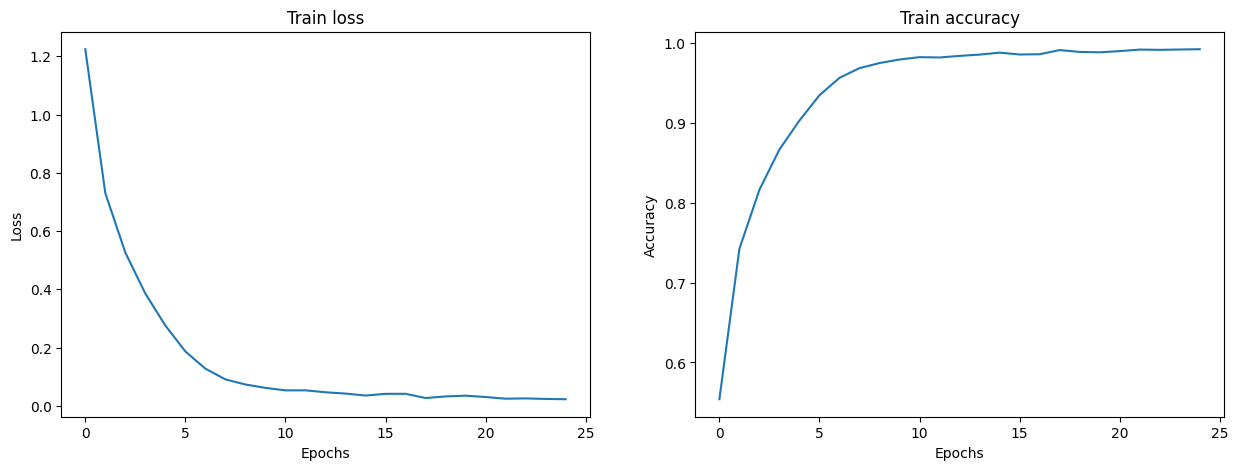

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(loss_for_graph)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title("Train loss")

axs[1].plot(acc_for_graph)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title("Train accuracy")

plt.show()

In [8]:
correct, total = 0, test_loader.dataset.data.shape[0]
loss, acc = 0.0, 0.0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        res = model(imgs)

        loss = loss_func(res, labels)
        loss += loss.item()

        _, predicted = res.max(1)
        correct += predicted.eq(labels).sum().item()
        acc += (predicted == labels).sum()

print(f'Test loss: {loss / total:5f}, test accuracy: {acc / total:5f}')

Test loss: 0.000309, test accuracy: 0.818200
